In [2]:
import gymnasium as gym
import numpy as np
import random
import wandb
from matplotlib import pyplot as plt
import pprint

In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: me21b145 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
sweep_config = {'method': 'random'}

metric = {
    'name': 'reward',
    'goal': 'maximize'   
    }
sweep_config['metric'] = metric

parameters = {
    'learning_rate': {'values': [0.2, 0.1, 0.05]},
    'discretization_bins': {'values': [100, 200, 300]},
    'episodes': {'values': [250, 500, 1000, 1500, 2000]},
    'discount_factor':{'value':0.99},
    'epsilon': {'values':[0.1, 0.2, 0.3]},
    'epsilon_decay': {'values':[0.01, 0.005, 0.001]},
    }
sweep_config['parameters'] = parameters

pprint.pprint(sweep_config)
sweep_id = wandb.sweep(sweep_config, project="RL_PA1_MountainCar_SARSA")

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'reward'},
 'parameters': {'discount_factor': {'value': 0.99},
                'discretization_bins': {'values': [100, 200, 300]},
                'episodes': {'values': [250, 500, 1000, 1500, 2000]},
                'epsilon': {'values': [0.1, 0.2, 0.3]},
                'epsilon_decay': {'values': [0.01, 0.005, 0.001]},
                'learning_rate': {'values': [0.2, 0.1, 0.05]}}}
Create sweep with ID: rd0mfpbx
Sweep URL: https://wandb.ai/me21b145/RL_PA1_MountainCar_SARSA/sweeps/rd0mfpbx


In [3]:
def train_sarsa(
    env,
    learning_rate=0.05,
    discount_factor=0.99,
    episodes=100000,
    epsilon=0.2,
    epsilon_decay=0.000002,
    discretization_bins=20,
    is_wandb = False
):  
    state_bins = [discretization_bins] * len(env.observation_space.high)
    bin_width = (env.observation_space.high - env.observation_space.low) / state_bins
    
    q_table = np.random.uniform(low=-2, high=0, size=(state_bins + [env.action_space.n]))
    rewards_per_episode = []
    return_per_episode = []
    
    for episode in range(episodes):
        state = tuple(((env.reset()[0] - env.observation_space.low) / bin_width).astype(int))
        total_reward = 0
        done = False
        time_steps = 0
        
        while not done:
            if np.random.random() > epsilon:
                action = np.argmax(q_table[state])
            else:
                action = np.random.choice(env.action_space.n)
                
            next_state, reward, done, _, _ = env.step(action)
            next_state_discrete = tuple(((next_state - env.observation_space.low) / bin_width).astype(int))
            
            if np.random.random() > epsilon:
                next_action = np.argmax(q_table[next_state_discrete])
            else:
                next_action = np.random.choice(env.action_space.n)
            
            current_q = q_table[state + (action,)]
            future_q = q_table[next_state_discrete + (next_action,)]
            new_q = (1 - learning_rate) * current_q + learning_rate * (reward + discount_factor * future_q)
            q_table[state + (action,)] = new_q
            
            state, action = next_state_discrete, next_action
            total_reward += reward
            time_steps += 1
        
        rewards_per_episode.append(total_reward)
        if episode == 0:
            return_per_episode.append(total_reward)
        else:
            return_per_episode.append(return_per_episode[-1]*discount_factor + total_reward)
        print(episode, " episode done. Reward: ", total_reward)
        if is_wandb:
            wandb.log({'reward': total_reward, 'episode': episode})
            wandb.log({'length': time_steps, 'episode': episode})
        env.close()
        
        epsilon = max(epsilon - epsilon_decay,0)
    
    env.close()
    return q_table, rewards_per_episode, return_per_episode


In [7]:
def SARSA():
    env = gym.make("MountainCar-v0")
    env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=10000)
    config = None
    with wandb.init(config=config):
        q_table, rewards_per_episode = train_sarsa(env,
                                                   wandb.config.learning_rate,
                                                   wandb.config.discount_factor,
                                                   wandb.config.episodes,
                                                   wandb.config.epsilon,
                                                   wandb.config.epsilon_decay,
                                                   wandb.config.discretization_bins,
                                                   is_wandb = True)

        plt.figure(figsize=(12, 5))
        plt.plot(rewards_per_episode, label="Reward Per Episode")
        plt.xlabel("Episodes")
        plt.ylabel("Rewards")
        plt.title(f"SARSA Training on Mountain Car with Discretization Size {wandb.config.discretization_bins}, Learning Rate {wandb.config.learning_rate}, Episodes {wandb.config.episodes}")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'SARSA_Mountaincar_{wandb.config.discretization_bins}_{wandb.config.learning_rate}_{wandb.config.episodes}.png')

        wandb.log({'Discretization Size': wandb.config.discretization_bins, 'Learning Rate': wandb.config.learning_rate, 'Episodes': wandb.config.episodes, 'Rewards per episode': wandb.Image(plt)})
        plt.close()

        env.close()

In [8]:
wandb.agent(sweep_id, SARSA,count=5)

wandb: Agent Starting Run: zjp2ua2t with config:
wandb: 	discount_factor: 0.99
wandb: 	discretization_bins: 300
wandb: 	episodes: 500
wandb: 	epsilon: 0.3
wandb: 	epsilon_decay: 0.01
wandb: 	learning_rate: 0.2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


0  episode done. Reward:  -31720.0
1  episode done. Reward:  -8853.0
2  episode done. Reward:  -40125.0
3  episode done. Reward:  -125382.0
4  episode done. Reward:  -7498.0
5  episode done. Reward:  -104696.0
6  episode done. Reward:  -50253.0
7  episode done. Reward:  -21254.0
8  episode done. Reward:  -9021.0
9  episode done. Reward:  -18118.0
10  episode done. Reward:  -8496.0
11  episode done. Reward:  -37110.0
12  episode done. Reward:  -35845.0
13  episode done. Reward:  -22881.0
14  episode done. Reward:  -8071.0
15  episode done. Reward:  -6052.0
16  episode done. Reward:  -3967.0
17  episode done. Reward:  -2240.0
18  episode done. Reward:  -4155.0
19  episode done. Reward:  -2932.0
20  episode done. Reward:  -38997.0
21  episode done. Reward:  -24194.0
22  episode done. Reward:  -5727.0
23  episode done. Reward:  -1611.0
24  episode done. Reward:  -9329.0
25  episode done. Reward:  -9480.0
26  episode done. Reward:  -7105.0
27  episode done. Reward:  -4276.0
28  episode done

c:\Users\rudra\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\rudra\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


Discretization Size,▁
Episodes,▁
Learning Rate,▁
episode,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█████
length,█▄▁▃▂▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▅▁▆▅▇▅▆▇▇▅▇▇█▆▇▇▆▂▃▇▇▇▆███▆█▇█▇▅▇██▇█▇██
Discretization Size,300
Episodes,500
Learning Rate,0.2
episode,499
length,1384


wandb: Agent Starting Run: pvryzhof with config:
wandb: 	discount_factor: 0.99
wandb: 	discretization_bins: 100
wandb: 	episodes: 500
wandb: 	epsilon: 0.1
wandb: 	epsilon_decay: 0.005
wandb: 	learning_rate: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


0  episode done. Reward:  -6581.0
1  episode done. Reward:  -7593.0
2  episode done. Reward:  -33762.0
3  episode done. Reward:  -5568.0
4  episode done. Reward:  -39329.0
5  episode done. Reward:  -33091.0
6  episode done. Reward:  -18541.0
7  episode done. Reward:  -2463.0
8  episode done. Reward:  -9415.0
9  episode done. Reward:  -8990.0
10  episode done. Reward:  -22694.0
11  episode done. Reward:  -13556.0
12  episode done. Reward:  -6228.0
13  episode done. Reward:  -20486.0
14  episode done. Reward:  -1840.0
15  episode done. Reward:  -7396.0
16  episode done. Reward:  -8326.0
17  episode done. Reward:  -7765.0
18  episode done. Reward:  -8883.0
19  episode done. Reward:  -2274.0
20  episode done. Reward:  -5846.0
21  episode done. Reward:  -11885.0
22  episode done. Reward:  -4821.0
23  episode done. Reward:  -6827.0
24  episode done. Reward:  -2477.0
25  episode done. Reward:  -9587.0
26  episode done. Reward:  -4572.0
27  episode done. Reward:  -1705.0
28  episode done. Rewa

Discretization Size,▁
Episodes,▁
Learning Rate,▁
episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
length,▃▄█▃▃▁▂▂▁▁▃▂▃▂▁▁▂▁▁▂▁▁▂▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁
reward,▇▁▆▃▅▅▅▇▂▅▄▇▆▅▅▆▇▇▇▇▇▇▇▅▇█▇█▇▆█▆▇▇▇▇███▇
Discretization Size,100
Episodes,500
Learning Rate,0.05
episode,499
length,1159


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: re4yvzu8 with config:
wandb: 	discount_factor: 0.99
wandb: 	discretization_bins: 300
wandb: 	episodes: 2000
wandb: 	epsilon: 0.3
wandb: 	epsilon_decay: 0.005
wandb: 	learning_rate: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


0  episode done. Reward:  -17578.0
1  episode done. Reward:  -20968.0
2  episode done. Reward:  -38334.0
3  episode done. Reward:  -36400.0
4  episode done. Reward:  -17766.0
5  episode done. Reward:  -14144.0
6  episode done. Reward:  -25808.0
7  episode done. Reward:  -82813.0
8  episode done. Reward:  -79653.0
9  episode done. Reward:  -20358.0
10  episode done. Reward:  -27483.0
11  episode done. Reward:  -3998.0
12  episode done. Reward:  -98702.0
13  episode done. Reward:  -54464.0
14  episode done. Reward:  -17011.0
15  episode done. Reward:  -6361.0
16  episode done. Reward:  -14554.0
17  episode done. Reward:  -49694.0
18  episode done. Reward:  -8224.0
19  episode done. Reward:  -8877.0
20  episode done. Reward:  -12340.0
21  episode done. Reward:  -20271.0
22  episode done. Reward:  -24795.0
23  episode done. Reward:  -3301.0
24  episode done. Reward:  -3931.0
25  episode done. Reward:  -3757.0
26  episode done. Reward:  -19844.0
27  episode done. Reward:  -7954.0
28  episod

Discretization Size,▁
Episodes,▁
Learning Rate,▁
episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇█████
length,█▅▂▁▃▁▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁
reward,▅▅▇▇▆▇▇▆▆▇▇▁▇▇▄█▇▆█▆▇▇█▇▇████▇███▇▇███▇█
Discretization Size,300
Episodes,2000
Learning Rate,0.05
episode,1999
length,1099


wandb: Agent Starting Run: mcv36tks with config:
wandb: 	discount_factor: 0.99
wandb: 	discretization_bins: 100
wandb: 	episodes: 1000
wandb: 	epsilon: 0.1
wandb: 	epsilon_decay: 0.005
wandb: 	learning_rate: 0.2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


0  episode done. Reward:  -3151.0
1  episode done. Reward:  -45424.0
2  episode done. Reward:  -20762.0
3  episode done. Reward:  -6057.0
4  episode done. Reward:  -3888.0
5  episode done. Reward:  -8765.0
6  episode done. Reward:  -5236.0
7  episode done. Reward:  -19052.0
8  episode done. Reward:  -6039.0
9  episode done. Reward:  -4888.0
10  episode done. Reward:  -2742.0
11  episode done. Reward:  -3938.0
12  episode done. Reward:  -4809.0
13  episode done. Reward:  -5752.0
14  episode done. Reward:  -4170.0
15  episode done. Reward:  -3325.0
16  episode done. Reward:  -4086.0
17  episode done. Reward:  -5474.0
18  episode done. Reward:  -2708.0
19  episode done. Reward:  -5226.0
20  episode done. Reward:  -3004.0
21  episode done. Reward:  -7983.0
22  episode done. Reward:  -2726.0
23  episode done. Reward:  -4362.0
24  episode done. Reward:  -2740.0
25  episode done. Reward:  -8816.0
26  episode done. Reward:  -810.0
27  episode done. Reward:  -1356.0
28  episode done. Reward:  -

Discretization Size,▁
Episodes,▁
Learning Rate,▁
episode,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇████
length,▄▆█▄▆▃▄▃▄▂▄▃▂▃▂▂▂▃▂▄▁▂▂▂▃▂▃▁▁▁▂▃▂▁▂▂▁▁▂▃
reward,▁▇█▇██▇▇█▇▇▇███▇███▇██▇▇████████████████
Discretization Size,100
Episodes,1000
Learning Rate,0.2
episode,999
length,387


wandb: Agent Starting Run: t34t05ty with config:
wandb: 	discount_factor: 0.99
wandb: 	discretization_bins: 300
wandb: 	episodes: 1000
wandb: 	epsilon: 0.2
wandb: 	epsilon_decay: 0.01
wandb: 	learning_rate: 0.2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


0  episode done. Reward:  -88236.0
1  episode done. Reward:  -109649.0
2  episode done. Reward:  -40402.0
3  episode done. Reward:  -3685.0
4  episode done. Reward:  -25612.0
5  episode done. Reward:  -22941.0
6  episode done. Reward:  -6047.0
7  episode done. Reward:  -23264.0
8  episode done. Reward:  -14170.0
9  episode done. Reward:  -1257.0
10  episode done. Reward:  -16536.0
11  episode done. Reward:  -11962.0
12  episode done. Reward:  -15016.0
13  episode done. Reward:  -19959.0
14  episode done. Reward:  -5859.0
15  episode done. Reward:  -4706.0
16  episode done. Reward:  -9498.0
17  episode done. Reward:  -15131.0
18  episode done. Reward:  -15297.0
19  episode done. Reward:  -8059.0
20  episode done. Reward:  -2787.0
21  episode done. Reward:  -5603.0
22  episode done. Reward:  -11738.0
23  episode done. Reward:  -5094.0
24  episode done. Reward:  -2403.0
25  episode done. Reward:  -21382.0
26  episode done. Reward:  -23518.0
27  episode done. Reward:  -6530.0
28  episode d

Discretization Size,▁
Episodes,▁
Learning Rate,▁
episode,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇█████
length,▅▆█▁▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▂▁▁▁▂▁▂▁▁▁▂▂
reward,▇▇▇▄▁█▇▇█▇▆██▇▇▇█▆██▇▇██▇█▇██▇▇█▇█▇██▇██
Discretization Size,300
Episodes,1000
Learning Rate,0.2
episode,999
length,2489


0  episode done. Reward:  -61941.0
1  episode done. Reward:  -11550.0
2  episode done. Reward:  -27122.0
3  episode done. Reward:  -7756.0
4  episode done. Reward:  -43902.0
5  episode done. Reward:  -23884.0
6  episode done. Reward:  -2924.0
7  episode done. Reward:  -3597.0
8  episode done. Reward:  -12229.0
9  episode done. Reward:  -7774.0
10  episode done. Reward:  -4503.0
11  episode done. Reward:  -16348.0
12  episode done. Reward:  -11130.0
13  episode done. Reward:  -2019.0
14  episode done. Reward:  -24261.0
15  episode done. Reward:  -12137.0
16  episode done. Reward:  -5260.0
17  episode done. Reward:  -7077.0
18  episode done. Reward:  -5942.0
19  episode done. Reward:  -6054.0
20  episode done. Reward:  -15504.0
21  episode done. Reward:  -5621.0
22  episode done. Reward:  -3337.0
23  episode done. Reward:  -4892.0
24  episode done. Reward:  -5153.0
25  episode done. Reward:  -5033.0
26  episode done. Reward:  -5651.0
27  episode done. Reward:  -3900.0
28  episode done. R

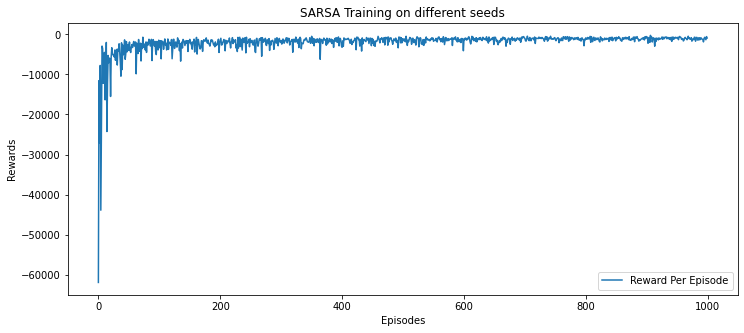

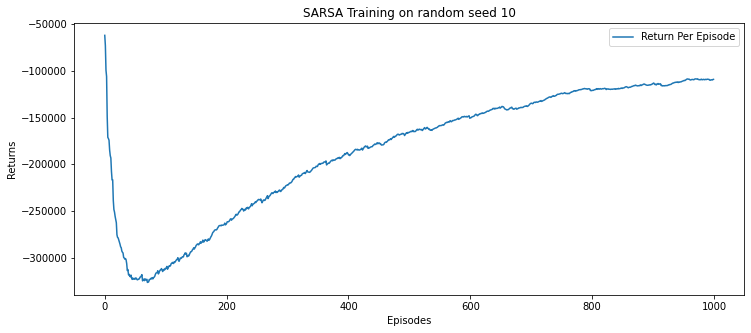

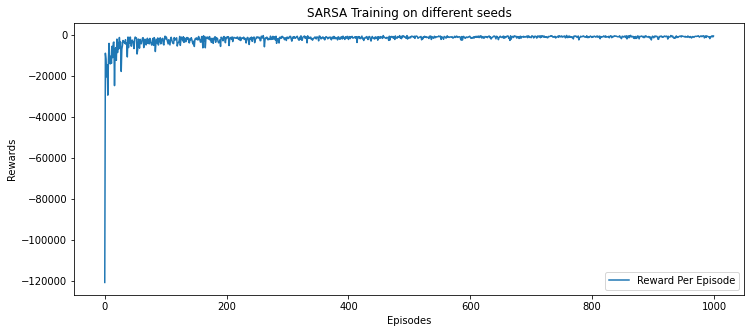

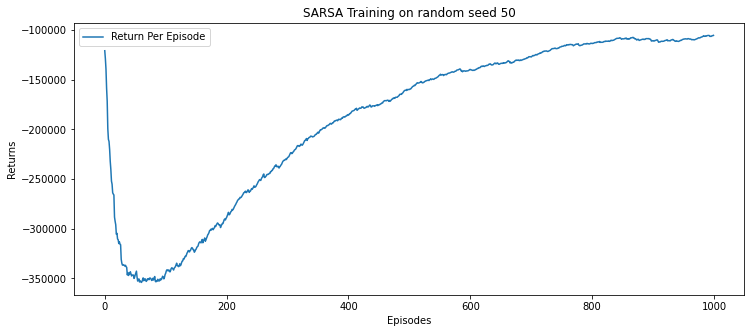

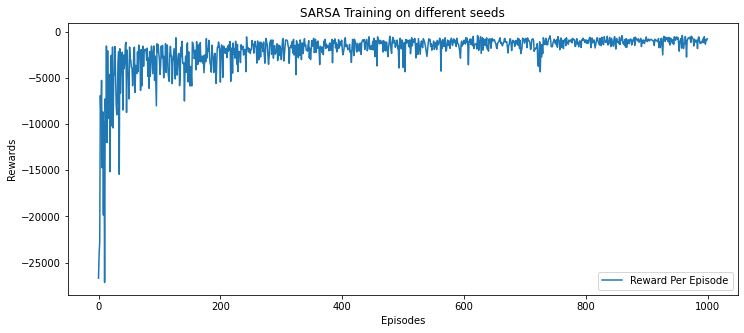

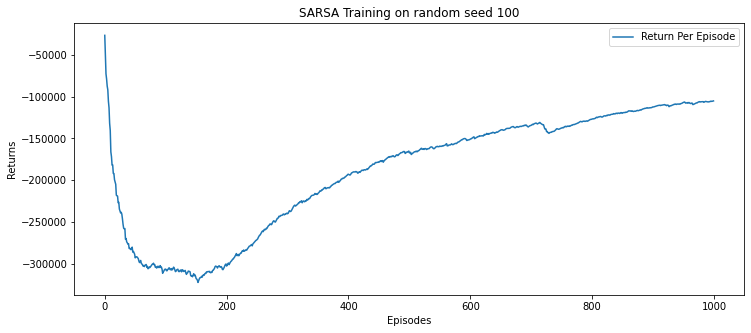

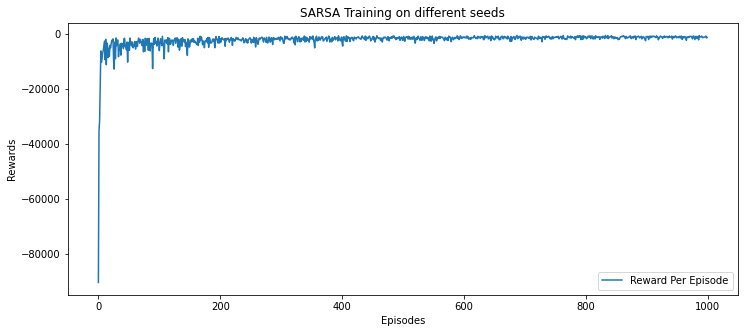

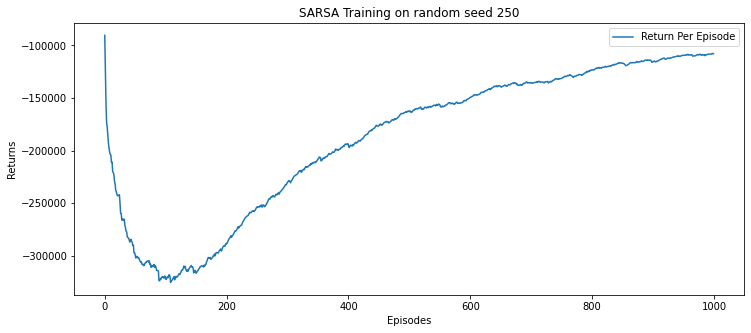

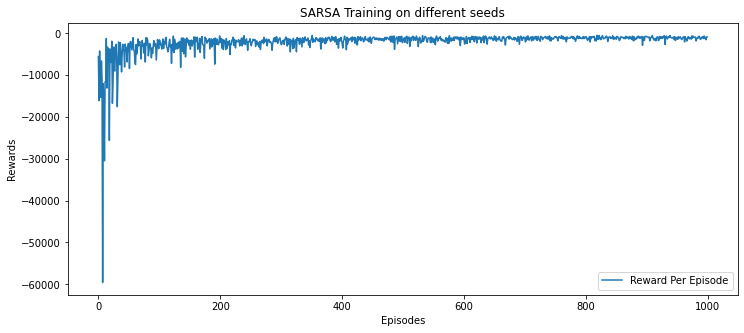

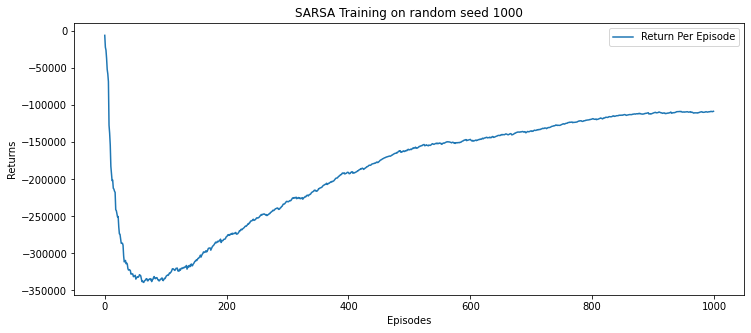

In [6]:
seeds = [10, 50, 100, 250, 1000]
rewards_avg = np.array([])
lengths_avg = np.array([])
rewards = np.array([])
env = gym.make("MountainCar-v0")
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=10000)

for seed in seeds:
    np.random.seed(seed)
    random.seed(seed)
    q_table, rewards_per_episode, return_per_episode = train_sarsa(env, learning_rate=0.05, discount_factor=0.99, episodes=1000, epsilon=0.3, epsilon_decay=0.005, discretization_bins=100, is_wandb=False)

    plt.figure(figsize=(12, 5))
    plt.plot(rewards_per_episode, label="Reward Per Episode")
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.title("SARSA Training on different seeds")
    plt.legend()

    plt.figure(figsize=(12, 5))
    plt.plot(return_per_episode, label="Return Per Episode")
    plt.xlabel("Episodes")
    plt.ylabel("Returns")
    plt.title(f"SARSA Training on random seed {seed}")
    plt.legend()
    
    print(f"Seed {seed} Done")